In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/butterfly-dataset/leedsbutterfly/README.txt
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0020155.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0090177.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0090201.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0100038.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0070055.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0060059.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0070068.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0070044.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0090114.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0070099.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0050049.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0020112.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0100023.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0040082.png
/kaggle/input/butt

In [2]:
import os
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


2025-06-10 18:45:42.688060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749581142.711468     227 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749581142.718472     227 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
image_path = '/kaggle/input/butterfly-dataset/leedsbutterfly/images/'
mask_path = '/kaggle/input/butterfly-dataset/leedsbutterfly/segmentations'

In [4]:
# list images and masks
images_list=os.listdir(image_path)
mask_list=os.listdir(mask_path)

print(f'mask={len(mask_list)}\timages={len(images_list)}')

mask=832	images=832


In [5]:
images_list[2]

'0090201.png'

In [6]:
def get_corresponding_mask(image_name):
    x = image_name.split('.')[0]
    return f'{x}_seg0.png'

In [7]:
get_corresponding_mask(images_list[0])

'0020155_seg0.png'

In [8]:
def show_samples(images_list, num_samples=3):
    plt.figure(figsize=(10,10))
    for i in range(num_samples):
        img = Image.open(os.path.join(image_path,images_list[i]))
        mask_name=get_corresponding_mask(images_list[i])
        mask = Image.open(os.path.join(mask_path,mask_name))

        plt.subplot(num_samples,2,2*i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('image')
        
        plt.subplot(num_samples,2,2*i+2)
        plt.imshow(mask)
        plt.axis('off')
        plt.title('mask')        

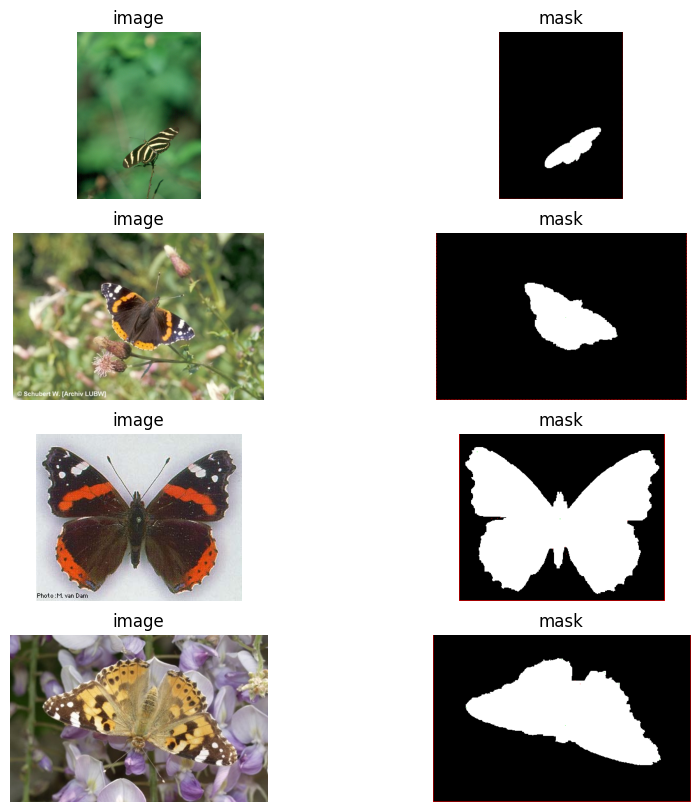

In [9]:
show_samples(images_list,4)

In [10]:
def get_corresponding_mask(image_name):
    x = image_name.split('.')[0]
    return f'{x}_seg0.png'

In [11]:
# Function to load and preprocess dataset
# loading data in numpy format generally works fast for data of size about 500 mb
def load_data(image_dir,mask_dir, image_size=256):
    """
    Loads and preprocesses images and masks for training

    Args:
        images_dir(str):Directory Containing the images
        mask_dir(str):Directroy Containing the masks
        image_size(int,optional):shape to resize images and masks. Default to 256.
    """

    image_list=[]
    mask_list=[]

    image_names = os.listdir(image_dir)
    mask_names = [get_corresponding_mask(name) for name in image_names]

    for image_name,mask_name in zip(image_names,mask_names):
        try:
            img = plt.imread(os.path.join(image_dir,image_name))
            mask = plt.imread(os.path.join(mask_dir,mask_name))
        except FileNotFoundError:
            print('File Not Fount')
            continue

        # resizing
        image_resized=cv2.resize(img,(image_size,image_size))
        mask_resized=cv2.resize(mask,(image_size,image_size))

        image_list.append(image_resized)
        mask_list.append(mask_resized[:,:,0])

    return np.array(image_list),np.array(mask_list)

In [12]:
image_dir = '/kaggle/input/butterfly-dataset/leedsbutterfly/images/'
mask_dir = '/kaggle/input/butterfly-dataset/leedsbutterfly/segmentations'
images,masks = load_data(image_dir,mask_dir,image_size=256)

In [13]:
# train_test_split
X_train, X_test, y_train,y_test = train_test_split(images,masks,test_size=0.2,random_state=125)

In [14]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((665, 256, 256, 3), (167, 256, 256, 3), (665, 256, 256), (167, 256, 256))

In [15]:
def convolution_block(input_tensor,num_filters,kernel_size=3,use_batch_norm=True):

    """
    Creates a convolution block of two convolution layers

    Args:
        input_tensor(tensor): Input to the convolution block.
        num_filters(int): Number of kernels in each convolution layer.
        kernel_size(int): Size of convolution kernels (both height and width). Default to 3.
        use_batch_norm(bool): Whether to use batch normalistion anfter convolution layers. Default to True.
        
    Returns:
        tensor: Output after applying convolution, batch Normalization and Activation
    """
    
    x=Conv2D(filters=num_filters,kernel_size=(kernel_size,kernel_size),padding='same',kernel_initializer='he_normal')(input_tensor)
    if use_batch_norm:
        x=BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
        
    x=Conv2D(filters=num_filters,kernel_size=(kernel_size,kernel_size),padding='same',kernel_initializer='he_normal')(input_tensor)
    if use_batch_norm:
        x=BatchNormalization()(x)
    x= tf.keras.layers.Activation('relu')(x)

    return x

In [16]:
def build_UNET(input_shape,num_filters=16,dropout_rate=0.1,use_batch_norm=True):

    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    c1 = convolution_block(inputs,num_filters=num_filters*1,use_batch_norm=use_batch_norm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropout_rate)(p1)

    c2 = convolution_block(p1,num_filters=num_filters*2,use_batch_norm=use_batch_norm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropout_rate)(p2)

    c3 = convolution_block(p2,num_filters=num_filters*4,use_batch_norm=use_batch_norm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropout_rate)(p3)

    c4 = convolution_block(p3,num_filters=num_filters*8,use_batch_norm=use_batch_norm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(dropout_rate)(p4)

    # BottleNeck
    c5 = convolution_block(p4,num_filters=num_filters*16,use_batch_norm=use_batch_norm)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(filters=num_filters*8,kernel_size=(3,3),strides=(2,2),padding='same')(c5)
    u6 = tf.keras.layers.concatenate([c4,u6])
    u6 = tf.keras.layers.Dropout(dropout_rate)(u6)
    u6 = convolution_block(u6,num_filters=num_filters*8,use_batch_norm=use_batch_norm)
    
    u7 = tf.keras.layers.Conv2DTranspose(filters=num_filters*4,kernel_size=(3,3),strides=(2,2),padding='same')(u6)
    u7 = tf.keras.layers.concatenate([c3,u7])
    u7 = tf.keras.layers.Dropout(dropout_rate)(u7)
    u7 = convolution_block(u7,num_filters=num_filters*4,use_batch_norm=use_batch_norm)
    
    u8 = tf.keras.layers.Conv2DTranspose(filters=num_filters*2,kernel_size=(3,3),strides=(2,2),padding='same')(u7)
    u8 = tf.keras.layers.concatenate([c2,u8])
    u8 = tf.keras.layers.Dropout(dropout_rate)(u8)
    u8 = convolution_block(u8,num_filters=num_filters*2,use_batch_norm=use_batch_norm)
    
    u9 = tf.keras.layers.Conv2DTranspose(filters=num_filters*1,kernel_size=(3,3),strides=(2,2),padding='same')(u8)
    u9 = tf.keras.layers.concatenate([c1,u9])
    u9 = tf.keras.layers.Dropout(dropout_rate)(u9)
    u9 = convolution_block(u9,num_filters=num_filters*1,use_batch_norm=use_batch_norm)

    # output_layer
    op = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(u9)

    # Model
    model = tf.keras.Model(inputs=[inputs],outputs=[op])

    return model

In [17]:
input_shape=(256,256,3)
unet_model=build_UNET(input_shape,dropout_rate=0.07)
unet_model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

I0000 00:00:1749581167.949849     227 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [19]:
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 64, 64, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)    

 Total params: 1,179,409 (4.50 MB)

 Trainable params: 1,177,937 (4.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
# #capture
# !pip install visualkeras

In [ ]:
# from visualkeras import layered_view
# import visualkeras
# visualkeras.layered_view(unet_model)

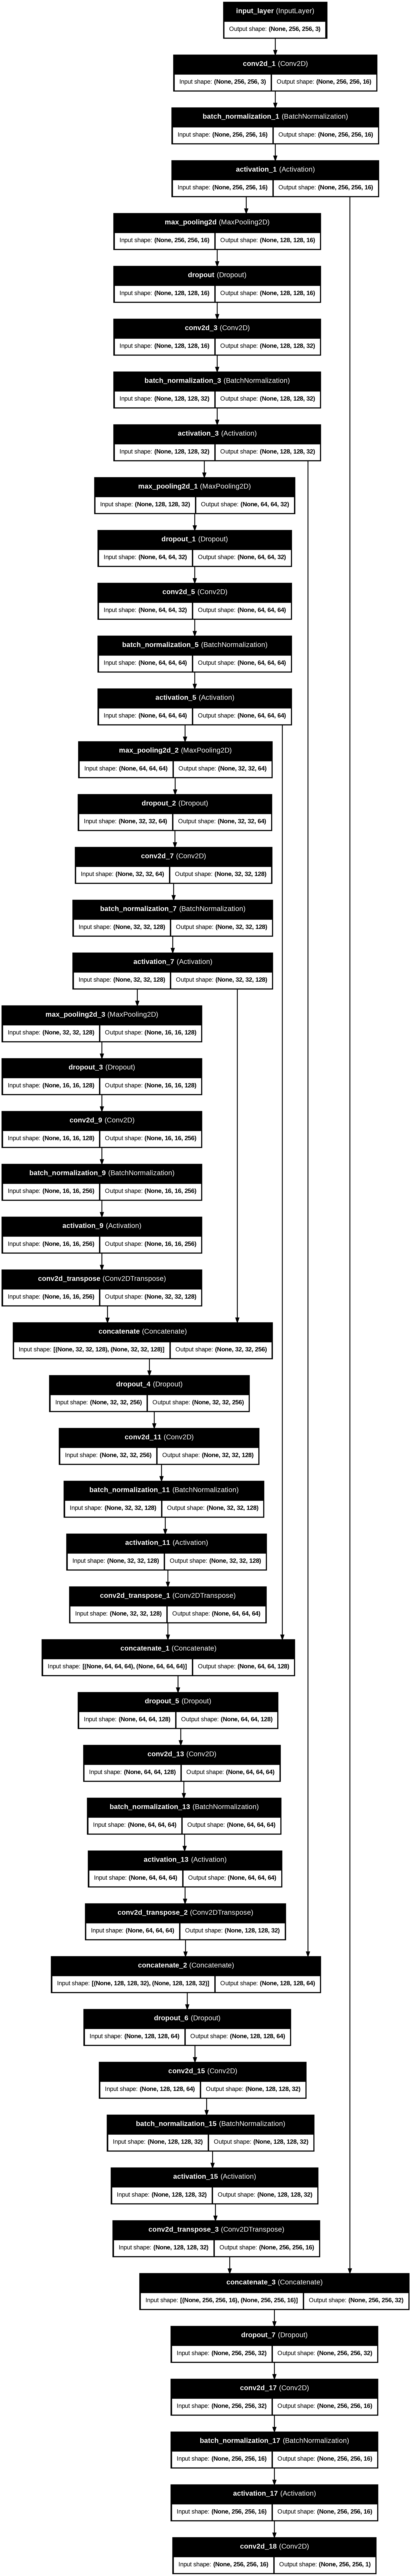

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(unet_model,to_file='unet.png',show_shapes=True,show_layer_names=True)

In [24]:
early_stopping=EarlyStopping(monitor='val_loss', patience=10, verbose =1,restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor='val loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)
model_checkpoint = ModelCheckpoint( 'unet_model_best.keras', monitor='val_loss', save_best_only=True, verbose=1 )

In [26]:
history = unet_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=75,verbose=1,callbacks=[early_stopping,reduce_lr,model_checkpoint])

Epoch 1/75
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9080 - loss: 0.2230 
Epoch 1: val_loss did not improve from 0.36329
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9081 - loss: 0.2229 - val_accuracy: 0.7746 - val_loss: 0.6329 - learning_rate: 0.0010
Epoch 2/75
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9137 - loss: 0.2054
Epoch 2: val_loss did not improve from 0.36329
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9138 - loss: 0.2053 - val_accuracy: 0.7850 - val_loss: 0.7329 - learning_rate: 0.0010
Epoch 3/75
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9185 - loss: 0.1902 
Epoch 3: val_loss did not improve from 0.36329
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9186 - loss: 0.1900 - val_accuracy: 0.7689 - val_loss: 0.8179 - learning_rate: 0.0010
Epoch 4/75
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9242 - loss: 0.1702 
Epoch 4: val_loss did not improve from 0.36329
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - acc

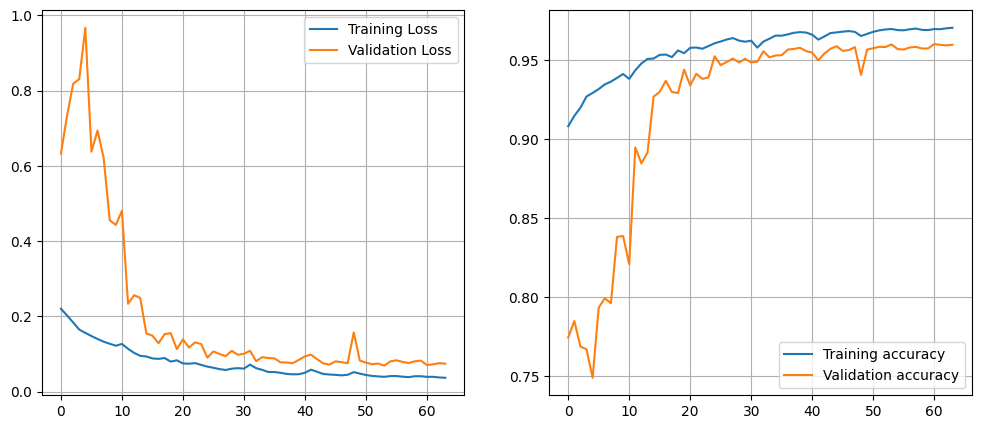

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.grid()


plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.legend()
plt.grid()
plt.show()

In [56]:
def visualize_segmentation_with_cropping(image, predicted_mask, ground_truth_mask):
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(16,4))

    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.title('original image')

    plt.subplot(1,4,2)
    plt.imshow(predicted_mask, cmap ='gray')
    plt.title('Predicted Mask')

    plt.subplot(1,4,3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    segmented_image = cv2.merge((binary_mask,binary_mask,binary_mask))*image

    plt.subplot(1,4,4)
    plt.imshow(segmented_image, cmap='gray')
    plt.title('segmented image')

    plt.show()
    

In [57]:
import numpy as np

def predict_single_image(sample_image, unet_model):
    """
    Predicts the segmentation mask for a single image using the provided U-Net model.
    
    Parameters:
        sample_image (np.ndarray): Input image with shape (256, 256, 3).
        unet_model (keras.Model): Trained U-Net model.
        
    Returns:
        np.ndarray: Prediction result (e.g., segmentation mask).
    """
    if sample_image.shape != (256, 256, 3):
        raise ValueError("Input image must have shape (256, 256, 3)")
    
    # Expand dims to simulate a batch of size 1
    image_batch = np.expand_dims(sample_image, axis=0)
    
    # Predict using the model
    prediction = unet_model.predict(image_batch)
    
    
    # Optionally squeeze the batch dimension back out
    return np.squeeze(prediction, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


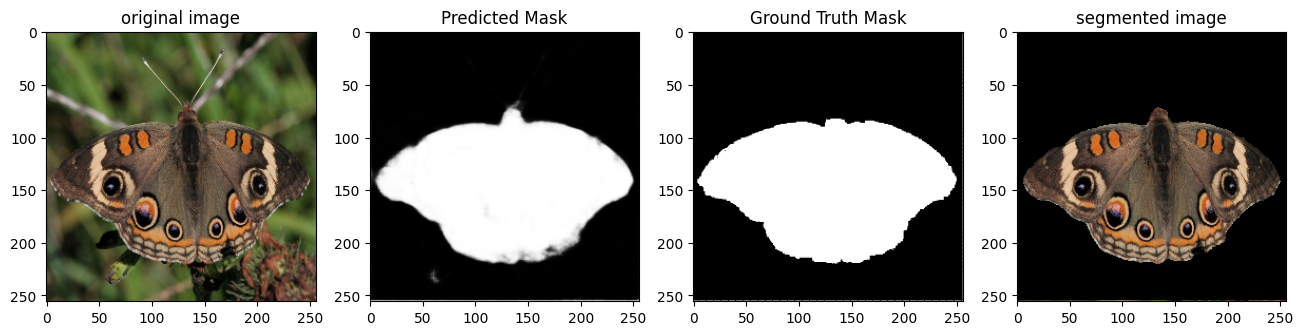

In [64]:
n=np.random.randint(low=0, high=167, size=None, dtype=int)

sample_image=X_test[n]
sample_ground_truth=y_test[n]

predicted_mask= predict_single_image(sample_image,unet_model)

visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)


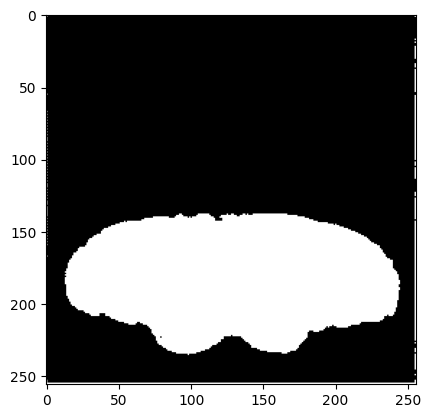

In [61]:
binary_mask = (predicted_mask > 0.5).astype(np.uint8)
plt.imshow(binary_mask,cmap='gray')

In [52]:
unet_model.save('unet_model_butterfly.keras')